# Example Of Using PySpark To Find Metal Interactions 

<br>
<img src="./figures/metal_interaction.png" width=600, align="left">
<br>

## Imports and variables

In [61]:
from pyspark import SparkConf, SparkContext                    
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.interactions import InteractionFilter, GroupInteractionExtractor
from mmtfPyspark.filters import ContainsLProteinChain, Resolution
from mmtfPyspark.webFilters import Pisces
from mmtfPyspark.structureViewer import group_interaction_viewer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import py3Dmol
import time
                                                               
# Create variables                                             
APP_NAME = "MMTF_Spark"                                        
path = "../../resources/mmtf_full_sample/"

# Configure Spark                                              
conf = SparkConf().setAppName(APP_NAME).setMaster("local[*]")  
sc = SparkContext(conf=conf)                                   

## Read PDB and create PISCES non-redundant set

In [62]:
pdb = mmtfReader.read_sequence_file(path, sc)
pdb = pdb.filter(Pisces(sequenceIdentity = 30, resolution = 2.5))         

## Setup criteria for metal interactions

In [63]:
# chemical component codes of metals in different oxidation states
metals = {"V","CR","MN","MN3","FE","FE2","CO","3CO","NI","3NI", "CU","CU1","CU3","ZN","MO","4MO","6MO"}

interactions_filter = InteractionFilter()
interactions_filter.set_distance_cutoff(distanceCutoff = 3.0)
interactions_filter.set_min_interactions(minInteractions = 4)
interactions_filter.set_max_interactions(maxInteractions = 6)
interactions_filter.set_query_groups(True, metals)

#Exclude non-polar interactions
interactions_filter.set_target_elements(False, ['H','C','P'])

## Tabulate interactions in a Dataframe

In [64]:
interactions = GroupInteractionExtractor().get_interactions(pdb,interactions_filter).cache()
print(f"Metal interactions: {interactions.count()}")

Metal interactions: 3340


## Select interacting atoms and orientational order parameters (q4-q6)

In [65]:
interactions = interactions.select("pdbId", \
                "q4","q5","q6", \
                "element0","groupNum0","chain0", \
                "element1","groupNum1","chain1","distance1", \
                "element2","groupNum2","chain2","distance2", \
                "element3","groupNum3","chain3","distance3", \
                "element4","groupNum4","chain4","distance4", \
                "element5","groupNum5","chain5","distance5", \
                "element6","groupNum6","chain6","distance6").cache();

# show some example interactions
ds = interactions.dropDuplicates(["pdbId"])
df = ds.toPandas() # convert to pandas dataframe to fit table in jupyter notebook cell
df.head()

,pdbId,q4,q5,q6,element0,groupNum0,chain0,element1,groupNum1,chain1,...,chain4,distance4,element5,groupNum5,chain5,distance5,element6,groupNum6,chain6,distance6
0,1M4L,0.810257,0.425694,NaN,Zn,1308,A,N,196,A,...,A,2.245983,N,69,A,2.034816,None,None,None,0.0
1,1VS0,0.471705,0.147339,NaN,Zn,9001,B,O,483,B,...,B,1.691909,O,481,B,1.897172,None,None,None,0.0
2,1YIX,0.683122,NaN,NaN,Zn,601,A,O,205,A,...,A,2.179354,None,None,None,0.000000,None,None,None,0.0
3,2ETV,0.622655,NaN,NaN,Ni,1,A,O,495,A,...,A,2.234011,None,None,None,0.000000,None,None,None,0.0
4,3A32,0.966021,NaN,NaN,Zn,708,A,N,166,A,...,A,2.064647,None,None,None,0.000000,None,None,None,0.0


## Count Unique interactions by metal

In [66]:
print("Unique interactions by metal: ")
unique_ds = interactions.groupBy(['element0']).count().sort("count")
unique_ds.show()

Unique interactions by metal: 
+--------+-----+
|element0|count|
+--------+-----+
|      Mo|   23|
|      Co|   86|
|      Cu|   88|
|      Ni|  166|
|      Fe|  405|
|      Mn|  435|
|      Zn| 2137|
+--------+-----+



## Violin plot using Seaborn

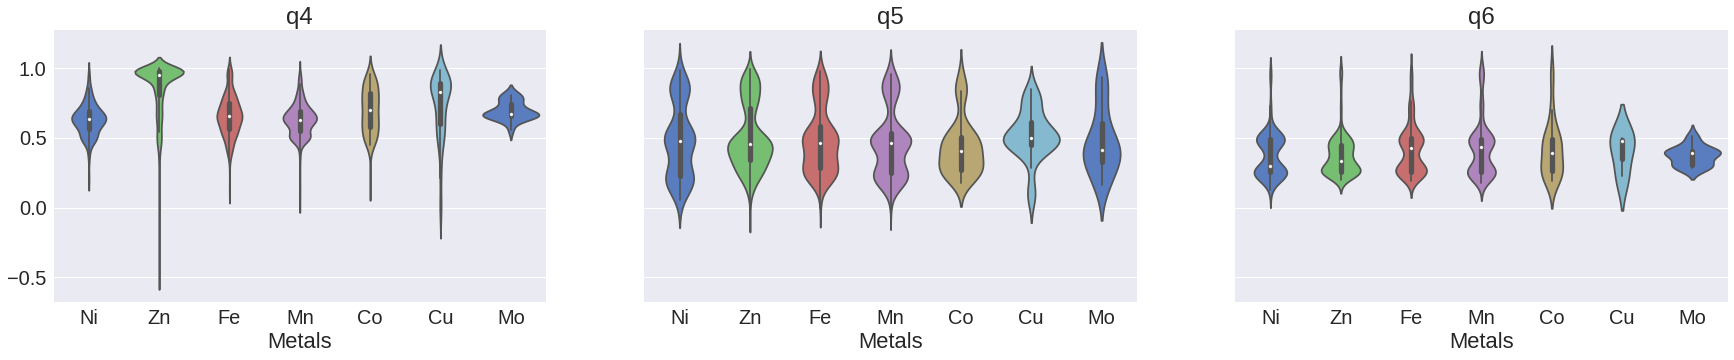

In [10]:
# tranform Dataset to pandas DataFrame
df = interactions.toPandas()

# Set fonts
sns.set(font_scale=2)

# Make subplots
fig, ax = plt.subplots(1,3, sharey = True, figsize = (30,5))

# Loop through subplots
for i in range(3):
    subplot = sns.violinplot(x="element0", y=f"q{i+4}", palette="muted", data=df, ax = ax[i])
    subplot.set(xlabel="Metals", ylabel="", title=f"q{i+4}")

## Create subset based on Metal and q values

In [67]:
df_sub = df[df["element0"] == 'Zn']    # Fitler only Zinc interactinos 
df_sub = df_sub.sort_values(["q4"], ascending = False).dropna(subset=['q4'])    #Sort by q4 values and drop NaN
df_sub = df_sub[df_sub['q5'] != np.nan]    # Revove interactions where q5 has values

df_sub.head(10)

,pdbId,q4,q5,q6,element0,groupNum0,chain0,element1,groupNum1,chain1,...,chain4,distance4,element5,groupNum5,chain5,distance5,element6,groupNum6,chain6,distance6
69,3WWL,0.999246,NaN,NaN,Zn,102,A,S,8,A,...,A,2.328847,None,None,None,0.0,None,None,None,0.0
751,1OQJ,0.998562,NaN,NaN,Zn,183,A,S,113,A,...,A,2.371518,None,None,None,0.0,None,None,None,0.0
106,1Q08,0.998095,NaN,NaN,Zn,401,A,O,301,A,...,A,2.426980,None,None,None,0.0,None,None,None,0.0
152,4RNA,0.998065,NaN,NaN,Zn,401,A,S,226,A,...,A,2.315423,None,None,None,0.0,None,None,None,0.0
84,3H0N,0.997777,NaN,NaN,Zn,201,A,S,168,A,...,A,2.297602,None,None,None,0.0,None,None,None,0.0
249,2VRW,0.997589,NaN,NaN,Zn,1565,B,N,516,B,...,B,2.428529,None,None,None,0.0,None,None,None,0.0
817,3UFF,0.997484,NaN,NaN,Zn,1,A,N,231,A,...,A,2.322295,None,None,None,0.0,None,None,None,0.0
266,5GVI,0.997407,NaN,NaN,Zn,601,A,S,283,A,...,A,2.301799,None,None,None,0.0,None,None,None,0.0
219,3H9C,0.997373,NaN,NaN,Zn,601,A,S,145,A,...,A,2.363166,None,None,None,0.0,None,None,None,0.0
686,2A6H,0.997304,NaN,NaN,Zn,7458,D,S,60,D,...,D,2.454053,None,None,None,0.0,None,None,None,0.0


## Visualize Data

In [68]:
group_interaction_viewer(df_sub, 'q4')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Structure', max=792), Output()), _dom_classes=('widget-interact',))

<function mmtfPyspark.structureViewer.group_interaction_viewer.<locals>.view3d>

## Terminate Spark

In [10]:
sc.stop()